In [3]:
import numpy as np
import cv2
from skimage import io, data
import napari
import matplotlib.pyplot as plt
import copy


#img = plt.imread('data/uoedh_culver house letters12659.jpg')


### Configuration

In [4]:


SHOW_FULLSIZE = False
DELAY = 2000                # in milliseconds
INPUT_PATH = 'data/'
OUTPUT_PATH = 'output/'
OUTPUT_THRESHOLD = 88       # Threshold for final output
CROPPING_THRESHOLD_UPPER = 255      # Threshold used to select the crop outline
CROPPING_THRESHOLD_LOWER = 250

# Filenames - without path or extension
fname = 'uoedh_culver house letters12660' # simple example
#fname = 'hl007138'
#fname = 'hl007140'
#fname = 'hl007150'
#fname = 'hl007179'

### Helper functions
* **makethumb()** is a quick rescaling function, reducing an image to 10% linear size
* **showbriefly()** shows an image for DELAY milliseconds or until a key is pressed

In [5]:
def makethumb(i):
    return cv2.resize(i,None,fx=0.1,fy=0.1,interpolation=cv2.INTER_CUBIC)

def showbriefly(i):
    WindowName = 'Image Viewer'
    view_window = cv2.namedWindow(WindowName, cv2.WINDOW_NORMAL)
    w = cv2.imshow(WindowName,i)
    # force focus
    cv2.setWindowProperty(WindowName,cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
    cv2.setWindowProperty(WindowName,cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_NORMAL)
    # wait 10 seconds
    cv2.waitKey(DELAY)
    cv2.destroyAllWindows()

def showinline(bgrimage, title):
    mpimg = cv2.cvtColor(bgrimage, cv2.COLOR_BGR2RGB)
    plt.imshow(mpimg)
    plt.title(title)
    plt.show()

### Get a list of files

In [6]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(INPUT_PATH) if isfile(join(INPUT_PATH, f))]
print(onlyfiles)

['hl007138.jpg', 'hl007140.jpg', 'hl007150.jpg', 'hl007179.jpg', 'uoedh_culver house letters12660.jpg']


In [7]:

for f in onlyfiles:
    print(f)

hl007138.jpg
hl007140.jpg
hl007150.jpg
hl007179.jpg
uoedh_culver house letters12660.jpg


### Read image using CV2 functions
* Image is loaded as a BGR matrix

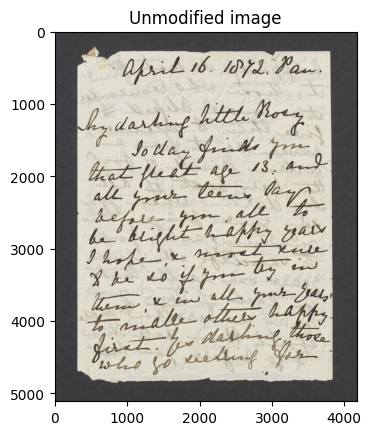

In [8]:
img = cv2.imread(filename=INPUT_PATH+fname+'.jpg')
#img = cv2.imread(filename=INPUT_PATH+f)
showinline(img,'Unmodified image')

### Convert image to greyscale

In [9]:
grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

### Use cv2.threshold() to isolate writing from background
* note that **cv2.threshold()** returns two arguments:
 * **ret** the threshold mask pattern (temporary variable)
 * **thresh** the image with threshold applied
 * Uses the adaptive **OTSU** algorithms for better results on uneven exposures

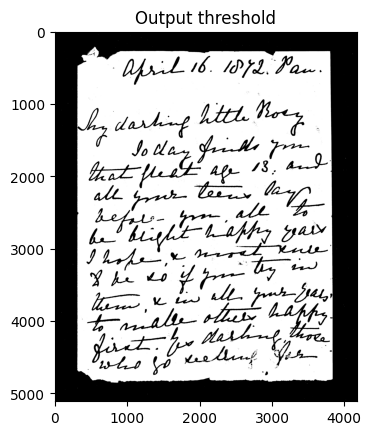

In [10]:
ret,thresh = cv2.threshold(grey,OUTPUT_THRESHOLD,255,cv2.THRESH_OTSU)

#showbriefly(makethumb(thresh))
showinline(thresh, 'Output threshold')

#### Find the Contours
* Redo the threshold with more extreme settings
* Find the contours of the objects in the image


From: https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv

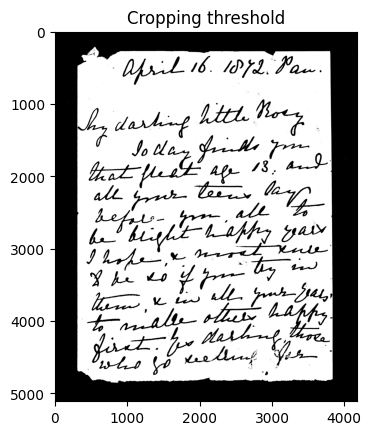

In [11]:
_, cropthresh = cv2.threshold(thresh,CROPPING_THRESHOLD_LOWER,CROPPING_THRESHOLD_UPPER,cv2.THRESH_BINARY)

contours,hierarchy = cv2.findContours(cropthresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

showinline(cropthresh, 'Cropping threshold')

In [12]:
maxc = []
maxa = 0
for c in contours:
    a = cv2.contourArea(c)
    if a>maxa:
        maxc=c
        maxa=a
        print('new maximum: '+str(maxa))
cont = maxc

new maximum: 1.5
new maximum: 3.0
new maximum: 4.0
new maximum: 8.0
new maximum: 10.5
new maximum: 11.0
new maximum: 29.0
new maximum: 15900882.0


#### Find the bounding rectangle of that maximal contour

In [13]:
x,y,w,h = cv2.boundingRect(cont)

print('x,y,x`,y` = ',x,y,x+w,y+h)
print('w,h = ',w,h)

x,y,x`,y` =  305 216 3834 4859
w,h =  3529 4643


#### Show the bounding box in green for confirmation
* Note that the **rectangle()** function modifies the image it references
 * Hence the need to do a **deepcopy()**

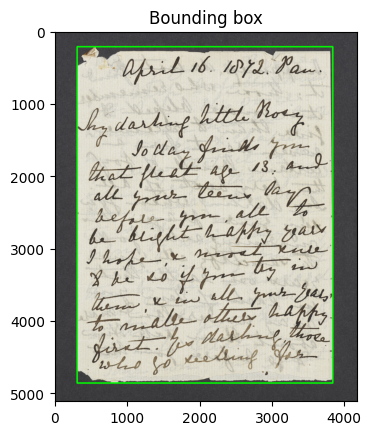

In [14]:
boundbox = copy.deepcopy(img)
cv2.rectangle(boundbox,(x,y),(x+w,y+h),(0,255,0),20)
showinline(boundbox, 'Bounding box')
showbriefly(boundbox)

#### Crop the original image using numpy matrix slicing

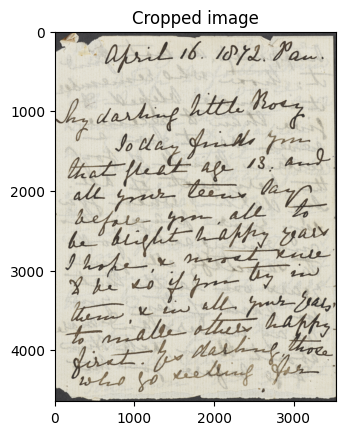

In [15]:
crop = img[y:y+h,x:x+w]
#showbriefly(crop)
showinline(crop, 'Cropped image')

#### And now thresholded image

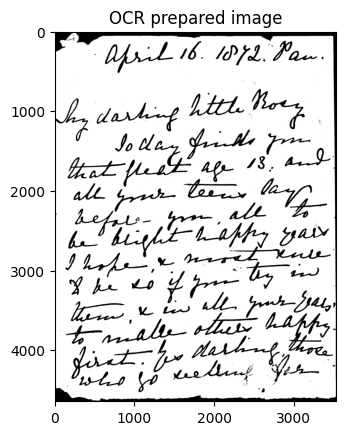

In [16]:
cropocr = thresh[y:y+h,x:x+w]
#showbriefly(cropocr)
showinline(cropocr,'OCR prepared image')

#showbriefly(makethumb(img))
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show()

In [17]:
cv2.destroyAllWindows()

In [19]:
print('Writing cropped colour image')
print(OUTPUT_PATH+fname)
_ = cv2.imwrite(img=crop,filename=OUTPUT_PATH+fname+'-cropped.jpg')
print('Writing cropped thresholded image for OCR processing')
_ = cv2.imwrite(img=cropocr, filename=OUTPUT_PATH+fname+'-thresholded.jpg')

Writing cropped colour image
output/uoedh_culver house letters12660
Writing cropped thresholded image for OCR processing
